**Create Custom Generators for feeding data to Neural Netowrk**

This code will show how to create custom generators using two different methods to feed data to neural network.
It uses Keras backend Sequence to create a custom class for our resize utility and make it thread safe.
The function blocks can run on parallel processing mode.

Furthermore, The resize uitlity uses Image pyramid scaling and a kernel filter on the resized image.

Later, in another section it also demonstrates how to fit a generator model to the neural network.

In [1]:
#### Dense Neural NW; Image Scaling using Gaussian Pyramid; Filters; Data Generartor (Sequence variant)

import numpy as np
import pandas as pd
import gc
import cv2

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from numpy import load



#========== Neural NW
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.models import Sequential
from keras import backend as K
import multiprocessing
import threading
from sklearn.utils import shuffle

print("Libraries Loaded")


Libraries Loaded


In [2]:
def Data_Loader(Batch_number):
    path ='../input/processed-batches/Batch' + str(Batch_number) 
    dict_Batch_X = load(path + '_X.npz')
    dict_Batch_Y = load(path + '_Y.npz')
    Xa = dict_Batch_X['arr_0']
    Ya = dict_Batch_Y['arr_0']
    print("Batch"+ str(Batch_number)+":", "Training Data Dim", Xa.shape,"  Label Data Dim:", Ya.shape)
    del dict_Batch_X
    del dict_Batch_Y
    return Xa, Ya


Test_Batch = 10


X_TEST, Y_TEST =  Data_Loader(Test_Batch)
X_TEST = X_TEST[:,:,:,0]  #single channel mode


X, Y = Data_Loader(1)
X = X[:,:,:,0]  #single channel mode


print("(X_TEST) Test Dataset's Dimensions:" ,X_TEST.shape,"label Dim: ", Y_TEST.shape)
print("(X)      Training Dataset's Dimensions:" ,X.shape,"label Dim: ", Y.shape)
print()


#Split Test images to Validation and Test
X_Tst, X_Val, Y_Tst, Y_Val = train_test_split(X_TEST, Y_TEST, test_size=0.5, random_state=0, stratify=Y_TEST)
print("Split Test Dataset's Dimensions:" ,X_Tst.shape,"label Dim: ", Y_Tst.shape)

#### X_Tst will stay hidden at all times

#Convert to one-hot
Y_Val=tf.one_hot(Y_Val, 1000)
Y_Tst=tf.one_hot(Y_Tst, 1000)
Y=tf.one_hot(Y, 1000)


gc.collect()

Batch10: Training Data Dim (100000, 8, 8, 3)   Label Data Dim: (100000,)
Batch1: Training Data Dim (100000, 8, 8, 3)   Label Data Dim: (100000,)
(X_TEST) Test Dataset's Dimensions: (100000, 8, 8) label Dim:  (100000,)
(X)      Training Dataset's Dimensions: (100000, 8, 8) label Dim:  (100000,)

Split Test Dataset's Dimensions: (50000, 8, 8) label Dim:  (50000,)


2022-07-19 13:36:35.579051: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-19 13:36:35.742639: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-19 13:36:35.743870: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-19 13:36:35.748667: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

22

Original Shape (8, 8)
(256, 256)
Larger Shape (256, 256)


20

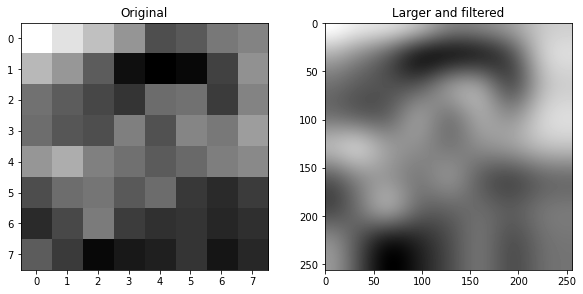

In [3]:
def Image_Pyramid_Scaler(image, filter_flag):
    kernel_Sharp = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
    levels = 4
    
    if filter_flag==1:
        image = cv2.filter2D(image, -1, kernel_Sharp)
    
    larger = cv2.pyrUp(image)
    for i in range(levels):
        larger = cv2.pyrUp(larger)
    #larger = larger[:,:,0]    #only if img is of 3 channel and needs to be in 1ch
    return larger


image = X[0]

plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.title("Original")
plt.imshow(image, cmap='gray')

print("Original Shape",image.shape)
larger = Image_Pyramid_Scaler(image,1)
print(larger.shape)
#larger = cv2.resize(larger, (224,224), interpolation = cv2.INTER_AREA)
plt.subplot(2, 2, 2)
plt.title("Larger and filtered")
plt.imshow(larger,cmap="gray")
print("Larger Shape",larger.shape)
gc.collect()

**This block will create tow different kinds of thread-safe Custom generators for our case.**

It uses Keras Sequence backend to create custom generator to feed large amount of data to network.


**How to make your custom iterator thread safe for parallel processing...**

[Threadsafe iter Reference](https://stackoverflow.com/questions/56441216/on-fit-generator-fit-and-thread-safety)

In [4]:
#This is one of the hackey methods that I searched for over the internet to convert your iterators to threadsafe.
class threadsafe_iter:
    """
    Takes an iterator/generator and makes it thread-safe by
    serializing call to the `next` method of given iterator/generator.
    """
    def __init__(self, it):
        self.it = it
        self.lock = threading.Lock()

    def __iter__(self):
        return self

    def __next__(self):
        with self.lock:
            return self.it.__next__()
    
    def __call__(self):
        self.i = 0
        return self

def threadsafe_generator(f):
    """A decorator that takes a generator function and makes it thread-safe."""
    def g(*a, **kw):
        return threadsafe_iter(f(*a, **kw))

    return g



# Function used to shuffle training data before feeding to the network.
def shuffle_data(data):
    data = shuffle(data)#,random_state=2)
    return data

class Resize_generator(tf.keras.utils.Sequence):
    
    def __init__(self, X_Dat, LBL, Test_mode, batch_size):
        self.x, self.y = X_Dat, LBL
        self.batch_size = batch_size
        self.test_mode = Test_mode
        self.num_samples = len(self.x)
    
       
    #The role of __getitem__ method is to generate one batch of data.
    # In this case, one batch of data will be (X, y) value pair.
        
    def __getitem__(self, idx):
        
        #eg: [0*100 to {(0+1)*100}] = [0 to 100] samples 
        batch_samples = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_Labels = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        
        # Initialise X_train and y_train arrays for this batch
        X_train = []
        y_train = []
        
        # For each example batch_samples in this array, do processing and store.... 
        for i in range(len(batch_samples)):

            # Load image (X) and label (y)

            # apply any kind of preprocessing
            #img = cv2.resize(img,(resize,resize))

            image = Image_Pyramid_Scaler(batch_samples[i], 1)  #Resized
            label = batch_Labels[i]

            # Add example to arrays
            X_train.append(image)
            y_train.append(label)

        # Make sure they're numpy arrays (as opposed to lists)
        X_train = np.array(X_train)
        y_train = np.array(y_train)
        
        return X_train, y_train
  
    
    def __len__(self):
        return (self.num_samples // self.batch_size)  #round-down floor. ceil will round-up, 300.2 will go to 301 in ceil case.
    
    
    def on_epoch_end(self):           #Shuffle data at the end of every epoch    
        if self.test_mode==0:
            self.x = shuffle(self.x)

            
# This is alternative method to use parallel computing. Make your iterator thread safe.
@threadsafe_generator
def Resize_generator_v1(X_Dat, LBL, Test_mode, batch_size):
    """
    Yields the next training batch.
    Suppose `samples` is an array [[image1_filename,label1], [image2_filename,label2],...].
    """
    num_samples = len(X_Dat)
    
    while True: # Loop forever so the generator never terminates
        if Test_mode==0:
            X_Dat = shuffle(X_Dat)
        
        # Get index to start each batch: [0, batch_size, 2*batch_size, ..., max multiple of batch_size <= num_samples]
        for offset in range(0, num_samples, batch_size):
            
            # Get the samples you'll use in this batch
            batch_samples = X_Dat[offset:offset+batch_size]
            batch_Labels = LBL[offset:offset+batch_size]
            
            # Initialise X_train and y_train arrays for this batch
            X_train = []
            y_train = []

            # For each example
            for i in range(len(batch_samples)):
                
                # Load image (X) and label (y)

                # apply any kind of preprocessing
                #img = cv2.resize(img,(resize,resize))
                
                image = Image_Pyramid_Scaler(batch_samples[i], 1)  #Resized
                label = batch_Labels[i]
                
                # Add example to arrays
                X_train.append(image)
                y_train.append(label)

            # Make sure they're numpy arrays (as opposed to lists)
            X_train = np.array(X_train)
            y_train = np.array(y_train)

            # The generator-y part: yield the next training batch            
            yield X_train, y_train



print("Functions and Classes Loaded")

Functions and Classes Loaded


**Create Generator Object for our custom Generator**

In [5]:
train_datagen = Resize_generator_v1(X, Y, 0, batch_size=100) #Custom generator to Resize images

Iterate over our custom generator to fetch new batches of data. "next()" is used to fetch next set of data. This will continue to fetch as many times as you call.

Resized Image Batch shape: (100, 256, 256)
One Hot Label Batch shape: (100, 1000)
40


6094

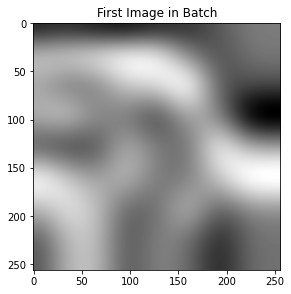

In [6]:
xa,ya = next(train_datagen)

plt.figure(figsize=(10, 10)) 
plt.subplot(2, 2, 1) 
plt.title("First Image in Batch") 
plt.imshow(xa[0], cmap='gray')

print("Resized Image Batch shape:",xa.shape) 
print("One Hot Label Batch shape:",ya.shape)

print(np.argmax(ya[0])) 
gc.collect()

***Apply This to DENSE Model***

In [7]:
# Create generator


train_generator = Resize_generator_v1(X, Y, 0, batch_size=200)  #Custom generator to Resize images
validation_generator = Resize_generator_v1(X_Val, Y_Val, 1,batch_size=200)  #Custom generator to Resize images
Test_generator = Resize_generator_v1(X_Tst, Y_Tst, 1, batch_size = 500)  #Custom generator to Resize images


#train_generator = Resize_generator(X, Y, 0, batch_size=200)  #Custom generator to Resize images
#validation_generator = Resize_generator(X_Val, Y_Val, 1,batch_size=200)  #Custom generator to Resize images
#Test_generator = Resize_generator(X_Tst, Y_Tst, 1, batch_size = 500)  #Custom generator to Resize images

In [8]:
model = Sequential()

model.add(keras.layers.Flatten(input_shape=(256,256)))  # Flatten input image to a vector


# Add a full connected layers
model.add(keras.layers.Dense(1024, activation='relu'))
model.add(keras.layers.Dense(512, activation='relu'))
model.add(keras.layers.Dense(256, activation='relu'))
model.add(keras.layers.Dense(128, activation='relu'))

model.add(keras.layers.Dense(1000, activation='softmax')) # Output layer

#tf.keras.optimizers.SGD(learning_rate=0.01) # Learning rate #FOR GPU KERNEL

#loss_fn=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False, reduction="auto", name="sparse_categorical_crossentropy")
loss_fn=tf.keras.losses.CategoricalCrossentropy(
    from_logits=False,
    label_smoothing=0.0,
    axis=-1,
    reduction="auto",
    name="categorical_crossentropy")

init_learning_rate = 0.1
decay_rate = init_learning_rate / 15

#tf.keras.optimizers.Adam(learning_rate=0.2, beta_1=0.9, beta_2=0.999,epsilon=1e-07, amsgrad=False, name='Adam')  #Adam Optimiser
opt = tf.keras.optimizers.SGD(learning_rate=init_learning_rate, momentum=0.9, decay=decay_rate)
#model.compile(loss='categorical_crossentropy',metrics=['accuracy'])

model.compile(loss=loss_fn,optimizer = opt, metrics=['accuracy'])
#model.compile(loss='kullback_leibler_divergence', optimizer=opt, metrics=['accuracy'])
#model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
#model.compile(optimizer='sgd', loss='mean_squared_logarithmic_error', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 65536)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              67109888  
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_3 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_4 (Dense)              (None, 1000)              129000    
Total params: 67,927,912
Trainable params: 67,927,912
Non-trainable params: 0
____________________________________________

Fit the generator instead of array of data. The function will automatically fetch data from our generator.

Provide 
>steps_per_epoch = num_train_samples // training_batch_size

>validation_steps = num_val_samples // training_batch_size


Number of Processors: 2


2022-07-19 13:36:41.235520: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/4
500/500 [==============================] - 160s 316ms/step - loss: 6.9039 - accuracy: 7.1000e-04 - val_loss: 6.9007 - val_accuracy: 0.0010
Epoch 2/4
500/500 [==============================] - 157s 315ms/step - loss: 6.9012 - accuracy: 9.3000e-04 - val_loss: 6.9006 - val_accuracy: 0.0010
Epoch 3/4
500/500 [==============================] - 159s 318ms/step - loss: 6.9009 - accuracy: 9.6000e-04 - val_loss: 6.9006 - val_accuracy: 0.0010
Epoch 4/4
100/100 [==============================] - 52s 523ms/step - loss: 6.9006 - accuracy: 0.0010
Accuracy of Test data is: 0.10000000474974513 %


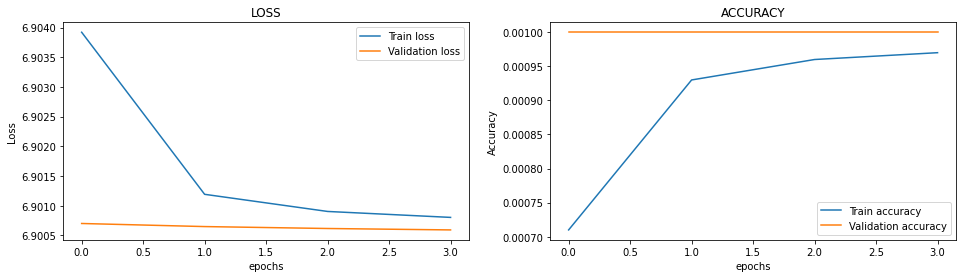

In [9]:
print("Number of Processors:",multiprocessing.cpu_count())
#K.set_value(model.optimizer.learning_rate, LR)
epcs = 4
training_batch_size = 200
tst_batch_size = 500

num_train_samples = len(X)
num_val_samples = len(X_Val)
num_tst_samples = len(X_Tst)

tr_hist = model.fit(
        train_generator, steps_per_epoch = num_train_samples // training_batch_size, epochs=epcs, verbose=1,
        validation_data = validation_generator, validation_steps = num_val_samples // training_batch_size, 
        workers=4) #, workers=2 , max_queue_size=150  use_multiprocessing=True

acc = model.evaluate(Test_generator, steps= num_tst_samples // tst_batch_size, verbose = 1)    #Test Data Accuracy
print(f'Accuracy of Test data is: {acc[1]*100} %')

#Plot graphs
plt.figure(figsize=(16,4))  
plt.subplot(1, 2, 1)

plt.plot(tr_hist.history['loss'],label="Train loss")
plt.plot(tr_hist.history['val_loss'],label="Validation loss", linestyle='-')
plt.title('LOSS')
plt.ylabel('Loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(tr_hist.history['accuracy'],label="Train accuracy")
plt.plot(tr_hist.history['val_accuracy'],label="Validation accuracy", linestyle='-')
plt.title('ACCURACY')
plt.ylabel('Accuracy')
plt.xlabel('epochs')
plt.legend(loc='lower right')
plt.show()
print()
print()
print()